In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ! scp -r arnab_sen_sharma@compute.safe.ai:/data/arnab_sen_sharma/Projects/relations/results ../../

In [3]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json

In [4]:
############################################
sweep_root = "../../results/sweep-colon"
model_name = "gptj"
############################################

sweep_path = f"{sweep_root}/{model_name}"

In [5]:
from src.sweeps import (
    SweepRelationResults,
    SweepTrialResults,
    SweepLayerResults,
    SweepTrainResults,
    SweepBetaResults, SweepRankResults, EfficacyTestPair
)
from src.data import RelationSample

def parse_results(sweep_result):
    relation_results = SweepRelationResults(
        relation_name=sweep_result["relation_name"],
        trials = []
    )

    for trial in sweep_result["trials"]:
        trial_results = SweepTrialResults(
            prompt_template=trial["prompt_template"],
            train_samples=[RelationSample.from_dict(s) for s in trial["train_samples"]],
            layers = [],
            n_test_samples=trial["n_test_samples"],
        )
        for layer in trial["layers"]:
            train_results = SweepTrainResults(
                samples = [RelationSample.from_dict(s) for s in layer["result"]["samples"]],
                betas = [],
                ranks = [],
                jh_norm=layer["result"]["jh_norm"],
            )
            for beta in layer["result"]["betas"]:
                beta_results = SweepBetaResults(
                    beta = beta["beta"],
                    recall = beta["recall"],
                    faithfulness_successes=[
                        RelationSample.from_dict(s) for s in beta["faithfulness_successes"]
                    ]
                )
                train_results.betas.append(beta_results)

            for rank in layer["result"]["ranks"]:
                rank_results = SweepRankResults(
                    rank = rank["rank"],
                    efficacy = rank["efficacy"],
                    efficacy_successes=[
                        EfficacyTestPair(
                            source=RelationSample.from_dict(s["source"]),
                            target=RelationSample.from_dict(s["target"]),
                        )
                        for s in rank["efficacy_successes"]
                    ]
                )
                train_results.ranks.append(rank_results)
            
            layer_results = SweepLayerResults(
                layer=layer["layer"],
                result=train_results
            )

            trial_results.layers.append(layer_results)
        relation_results.trials.append(trial_results)
    return relation_results

In [6]:
def plot_layerwise(canvas, relation_result, attribute = "recall", best_criterion = "faithfulness"):
    by_layer = relation_result.by_layer()

    layers = by_layer.keys()
    value_means = [value.__dict__[attribute].mean for value in by_layer.values()]
    value_stds = [value.__dict__[attribute].stdev for value in by_layer.values()]

    if(best_criterion == "faithfulness"):
        best_layer = relation_result.best_by_faithfulness()
    elif(best_criterion == "efficacy"):
        best_layer = relation_result.best_by_efficacy()
    canvas.scatter([best_layer.layer], [best_layer.__dict__[attribute].mean], color="red", s=200)
    canvas.plot(range(len(layers)), value_means, color='darkblue', linewidth=2)
    canvas.fill_between(range(len(layers)), np.array(value_means) - np.array(value_stds), np.array(value_means) + np.array(value_stds), color='lightblue', alpha=0.5)

    if attribute in ["recall", "efficacy"]:
        canvas.set_ylim(0, 1)
    else:
        canvas.set_ylim(bottom=0)
    canvas.set_xlabel("Layer")
    canvas.set_ylabel(attribute)
    canvas.set_xticks(range(len(layers)), layers, rotation=90)
    test_samples = [trial.n_test_samples for trial in relation_result.trials]
    canvas.set_title(f"{relation_result.relation_name} {test_samples}\n{best_criterion} => h_layer: {best_layer.layer}, beta: {best_layer.beta.mean:.2f}, rank: {best_layer.rank.mean:.2f}, efficacy: {best_layer.efficacy.mean:.2f}")
    
    return canvas

In [7]:
def read_sweep_results(sweep_path):
    sweep_results = {}

    for relation_folder in os.listdir(sweep_path):
        cur_sweep = f"{sweep_path}/{relation_folder}"
        if "results_all.json" not in os.listdir(cur_sweep):
            continue
        with open(f"{cur_sweep}/results_all.json") as f:
            res = json.load(f)["relations"]
            if(len(res) == 0 or len(res[0]["trials"]) ==  0):
                continue
            res = res[0]
            sweep_results[res["relation_name"]] = res
    return sweep_results

sweep_results = read_sweep_results(sweep_path)

list(sweep_results.keys())

['adjective antonym',
 'person mother',
 'country capital city',
 'person plays instrument',
 'city in country',
 'food from country',
 'occupation gender',
 'occupation age',
 'country language',
 'object superclass',
 'name religion',
 'president election year',
 'work location',
 'person lead singer of band',
 'task person type',
 'country largest city',
 'country currency',
 'fruit inside color',
 'task done by tool',
 'verb past tense',
 'star constellation name',
 'pokemon evolution',
 'name birthplace',
 'word last letter',
 'word sentiment',
 'company CEO',
 'superhero person',
 'substance phase of matter',
 'adjective superlative',
 'adjective comparative']

In [8]:
# dataset = data.load_dataset()
# all_relations = [
#     relation.name for relation in dataset.relations
# ]
# all_relations = sorted(all_relations)
# # all_relations
# failed_relations = list(set(all_relations) - set(sweep_results.keys()))
# failed_relations = sorted(failed_relations)
# failed_relations

/tmp/ipykernel_32646/677514173.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


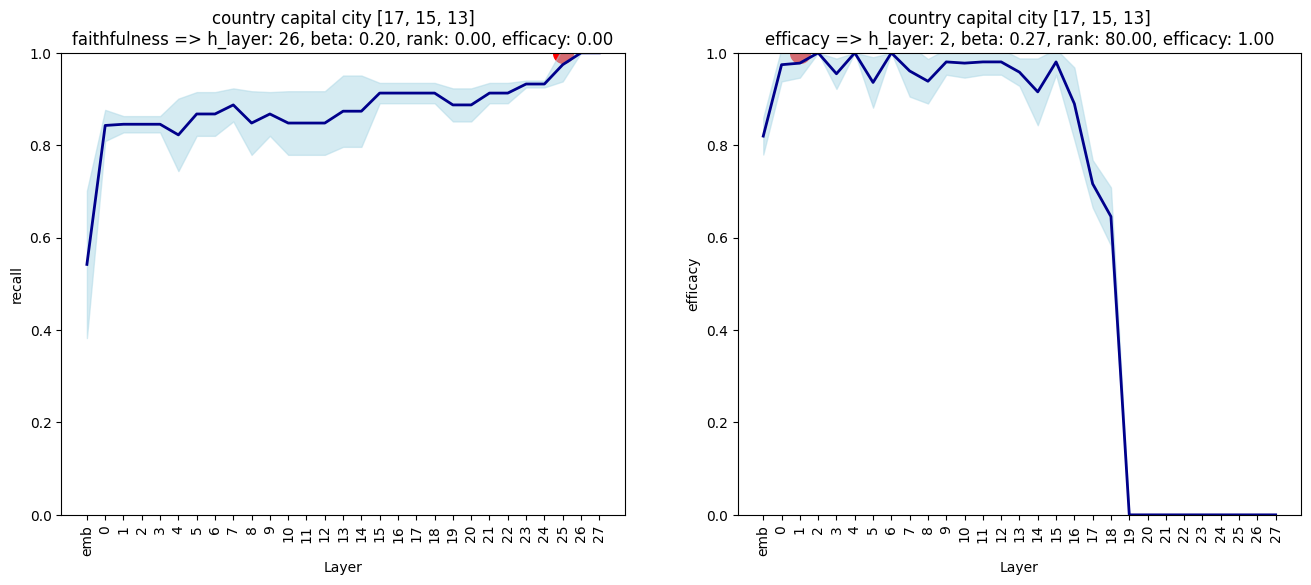

In [9]:
relation_result = parse_results(sweep_results['country capital city'])

nrows = 1
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6))

plot_layerwise(ax[0], relation_result)
plot_layerwise(ax[1], relation_result, attribute="efficacy", best_criterion="efficacy")

fig.show()

In [10]:
dataset = data.load_dataset()
interested_dataset = dataset.filter(
    # relation_type = ["factual"]
)

filtered_results = {}
for relation in interested_dataset.relations:
    if relation.name not in sweep_results:
        continue
    filtered_results[relation.name] = parse_results(sweep_results[relation.name])

In [11]:
len(filtered_results)

30

0 name birthplace
1 name religion
2 occupation age
3 occupation gender
4 fruit inside color


/tmp/ipykernel_32646/3229815679.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


5 object superclass
6 substance phase of matter
7 task person type
8 task done by tool
9 word sentiment
10 work location
11 city in country
12 company CEO
13 country capital city
14 country currency
15 country language
16 country largest city
17 food from country
18 person lead singer of band
19 person mother
20 person plays instrument
21 pokemon evolution
22 president election year
23 star constellation name
24 superhero person
25 adjective antonym
26 adjective comparative
27 adjective superlative
28 verb past tense
29 word last letter


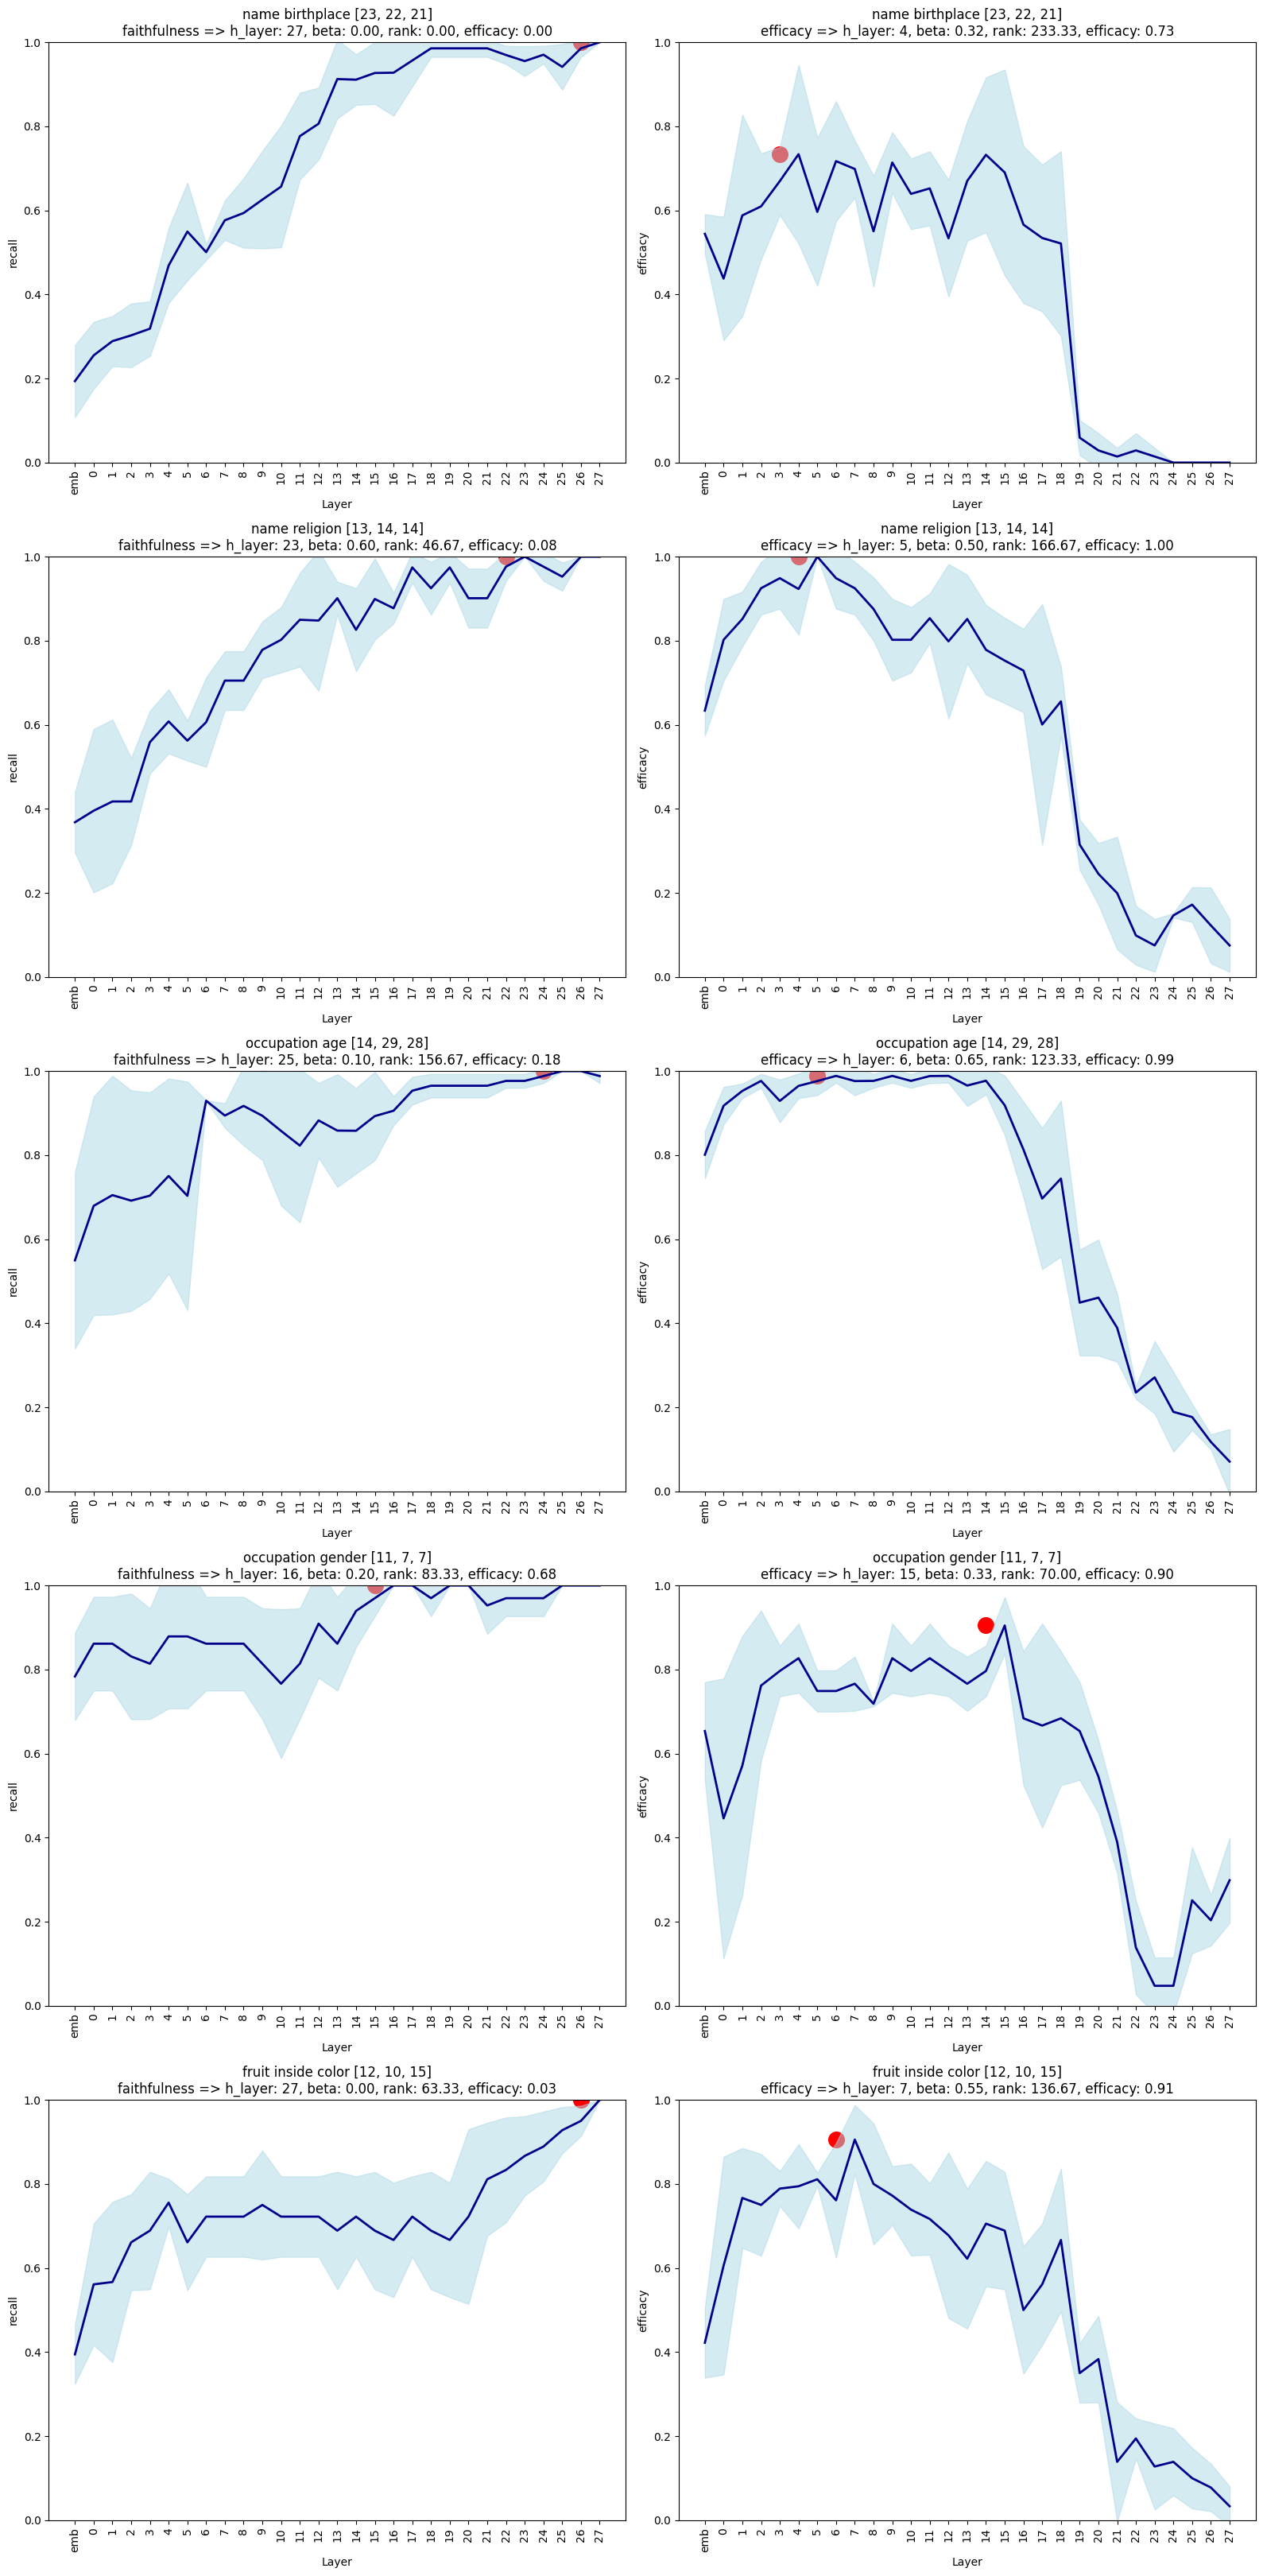

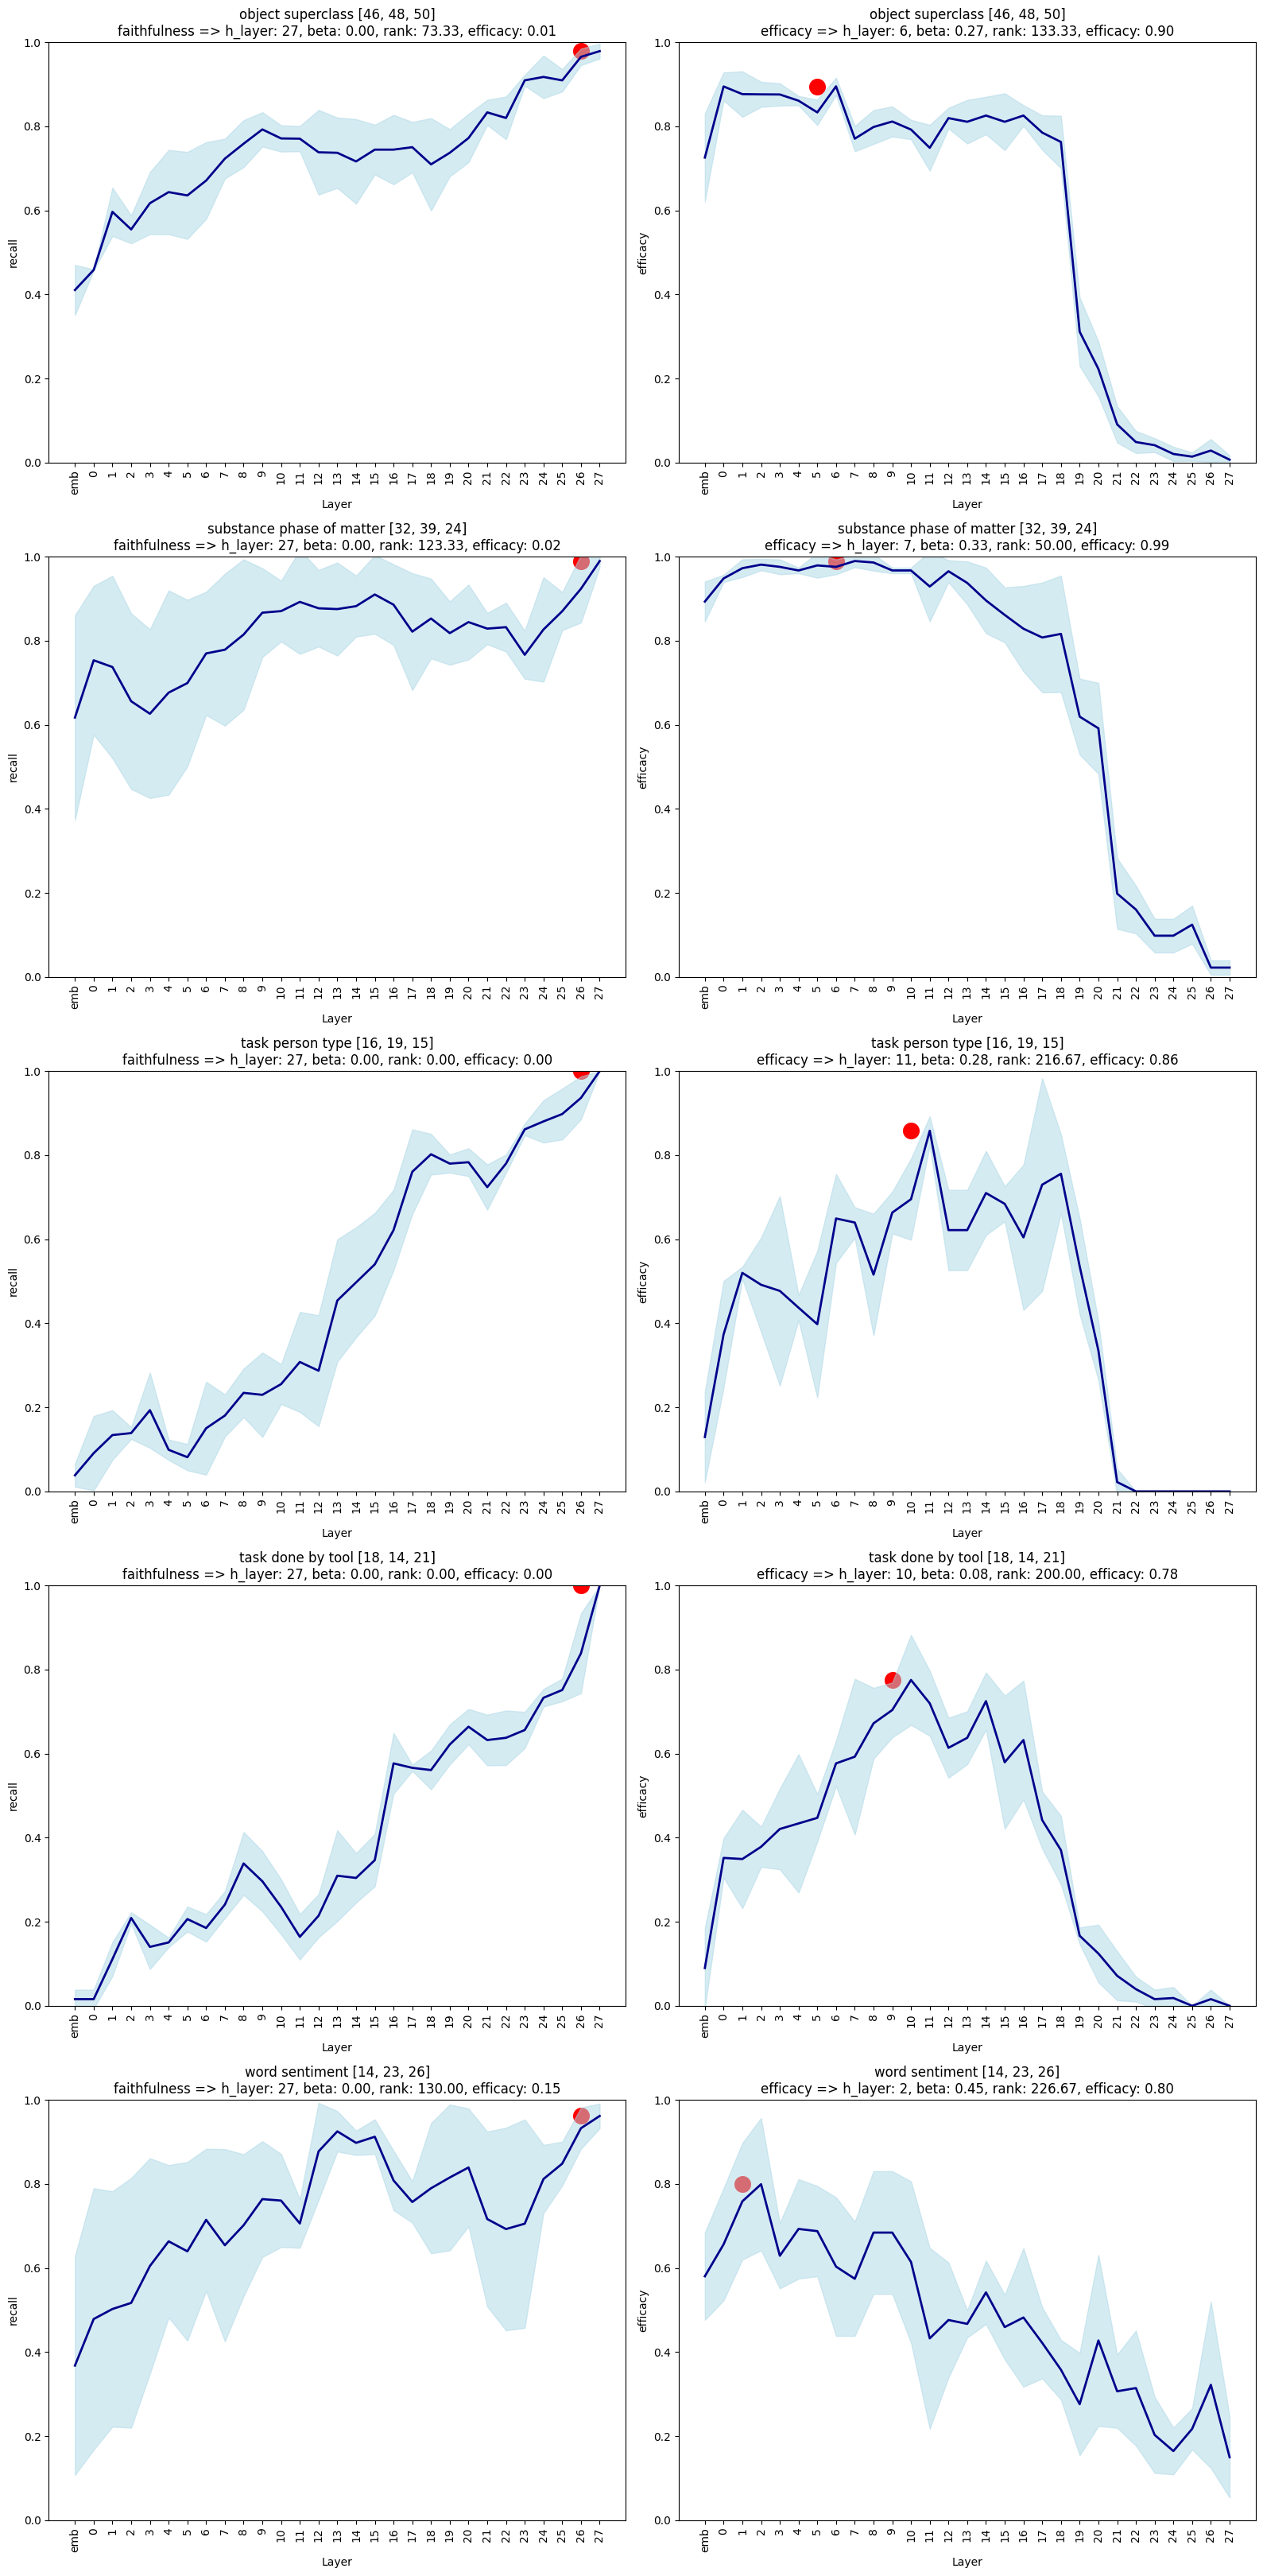

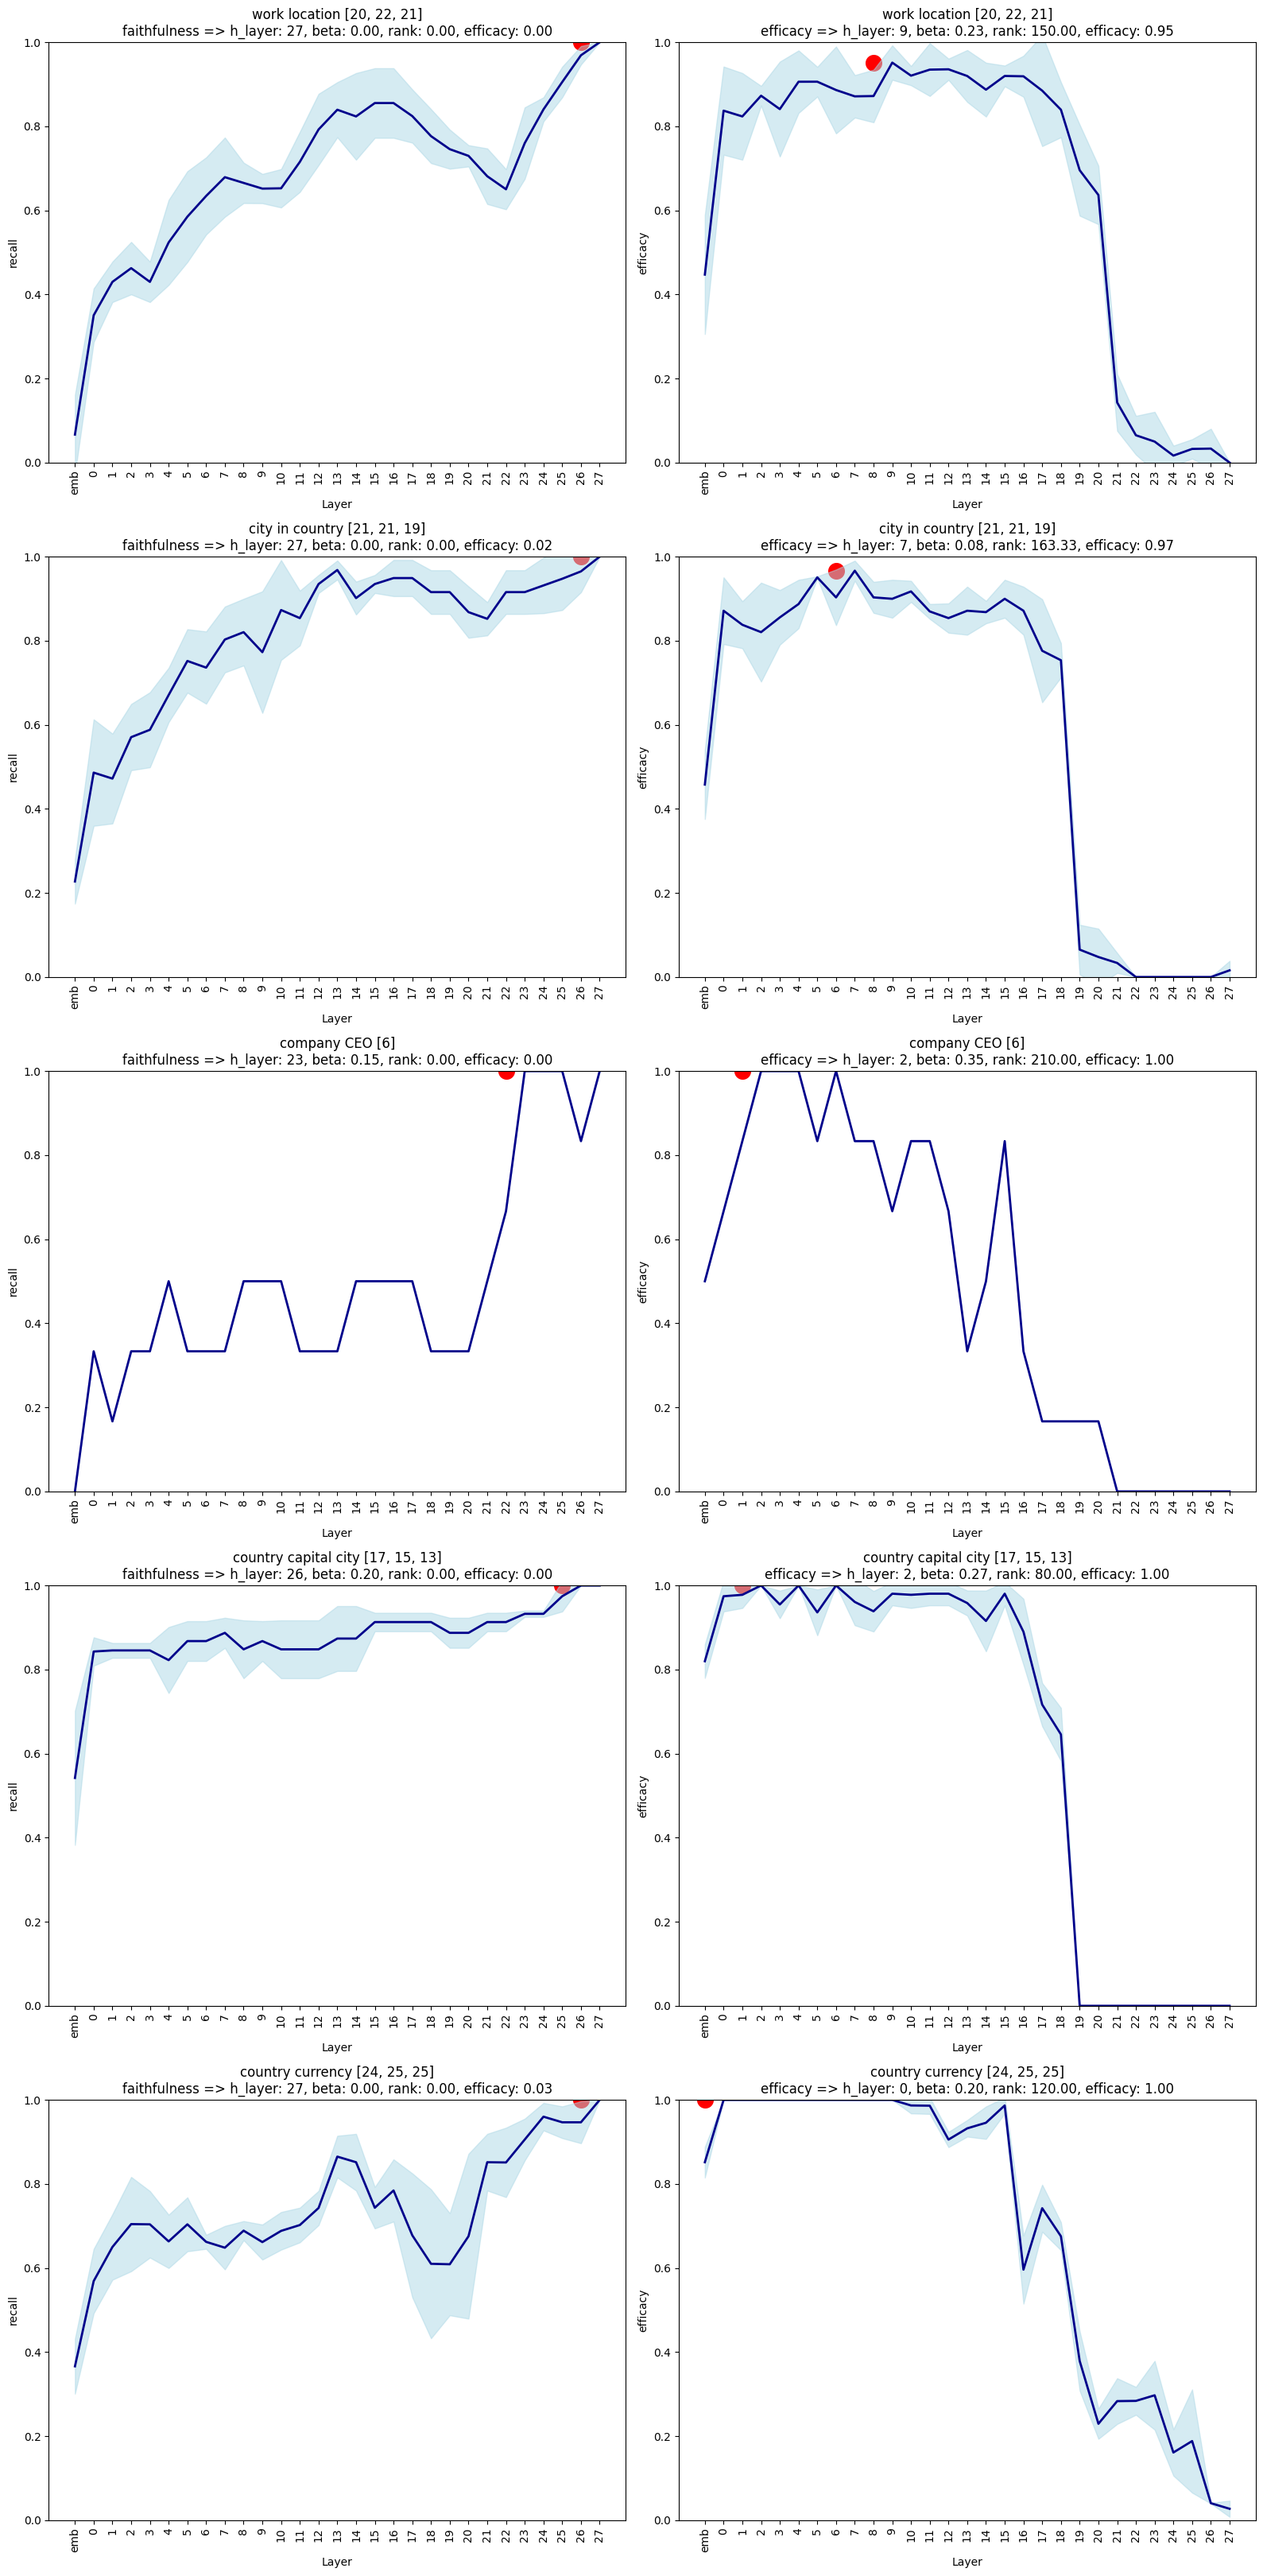

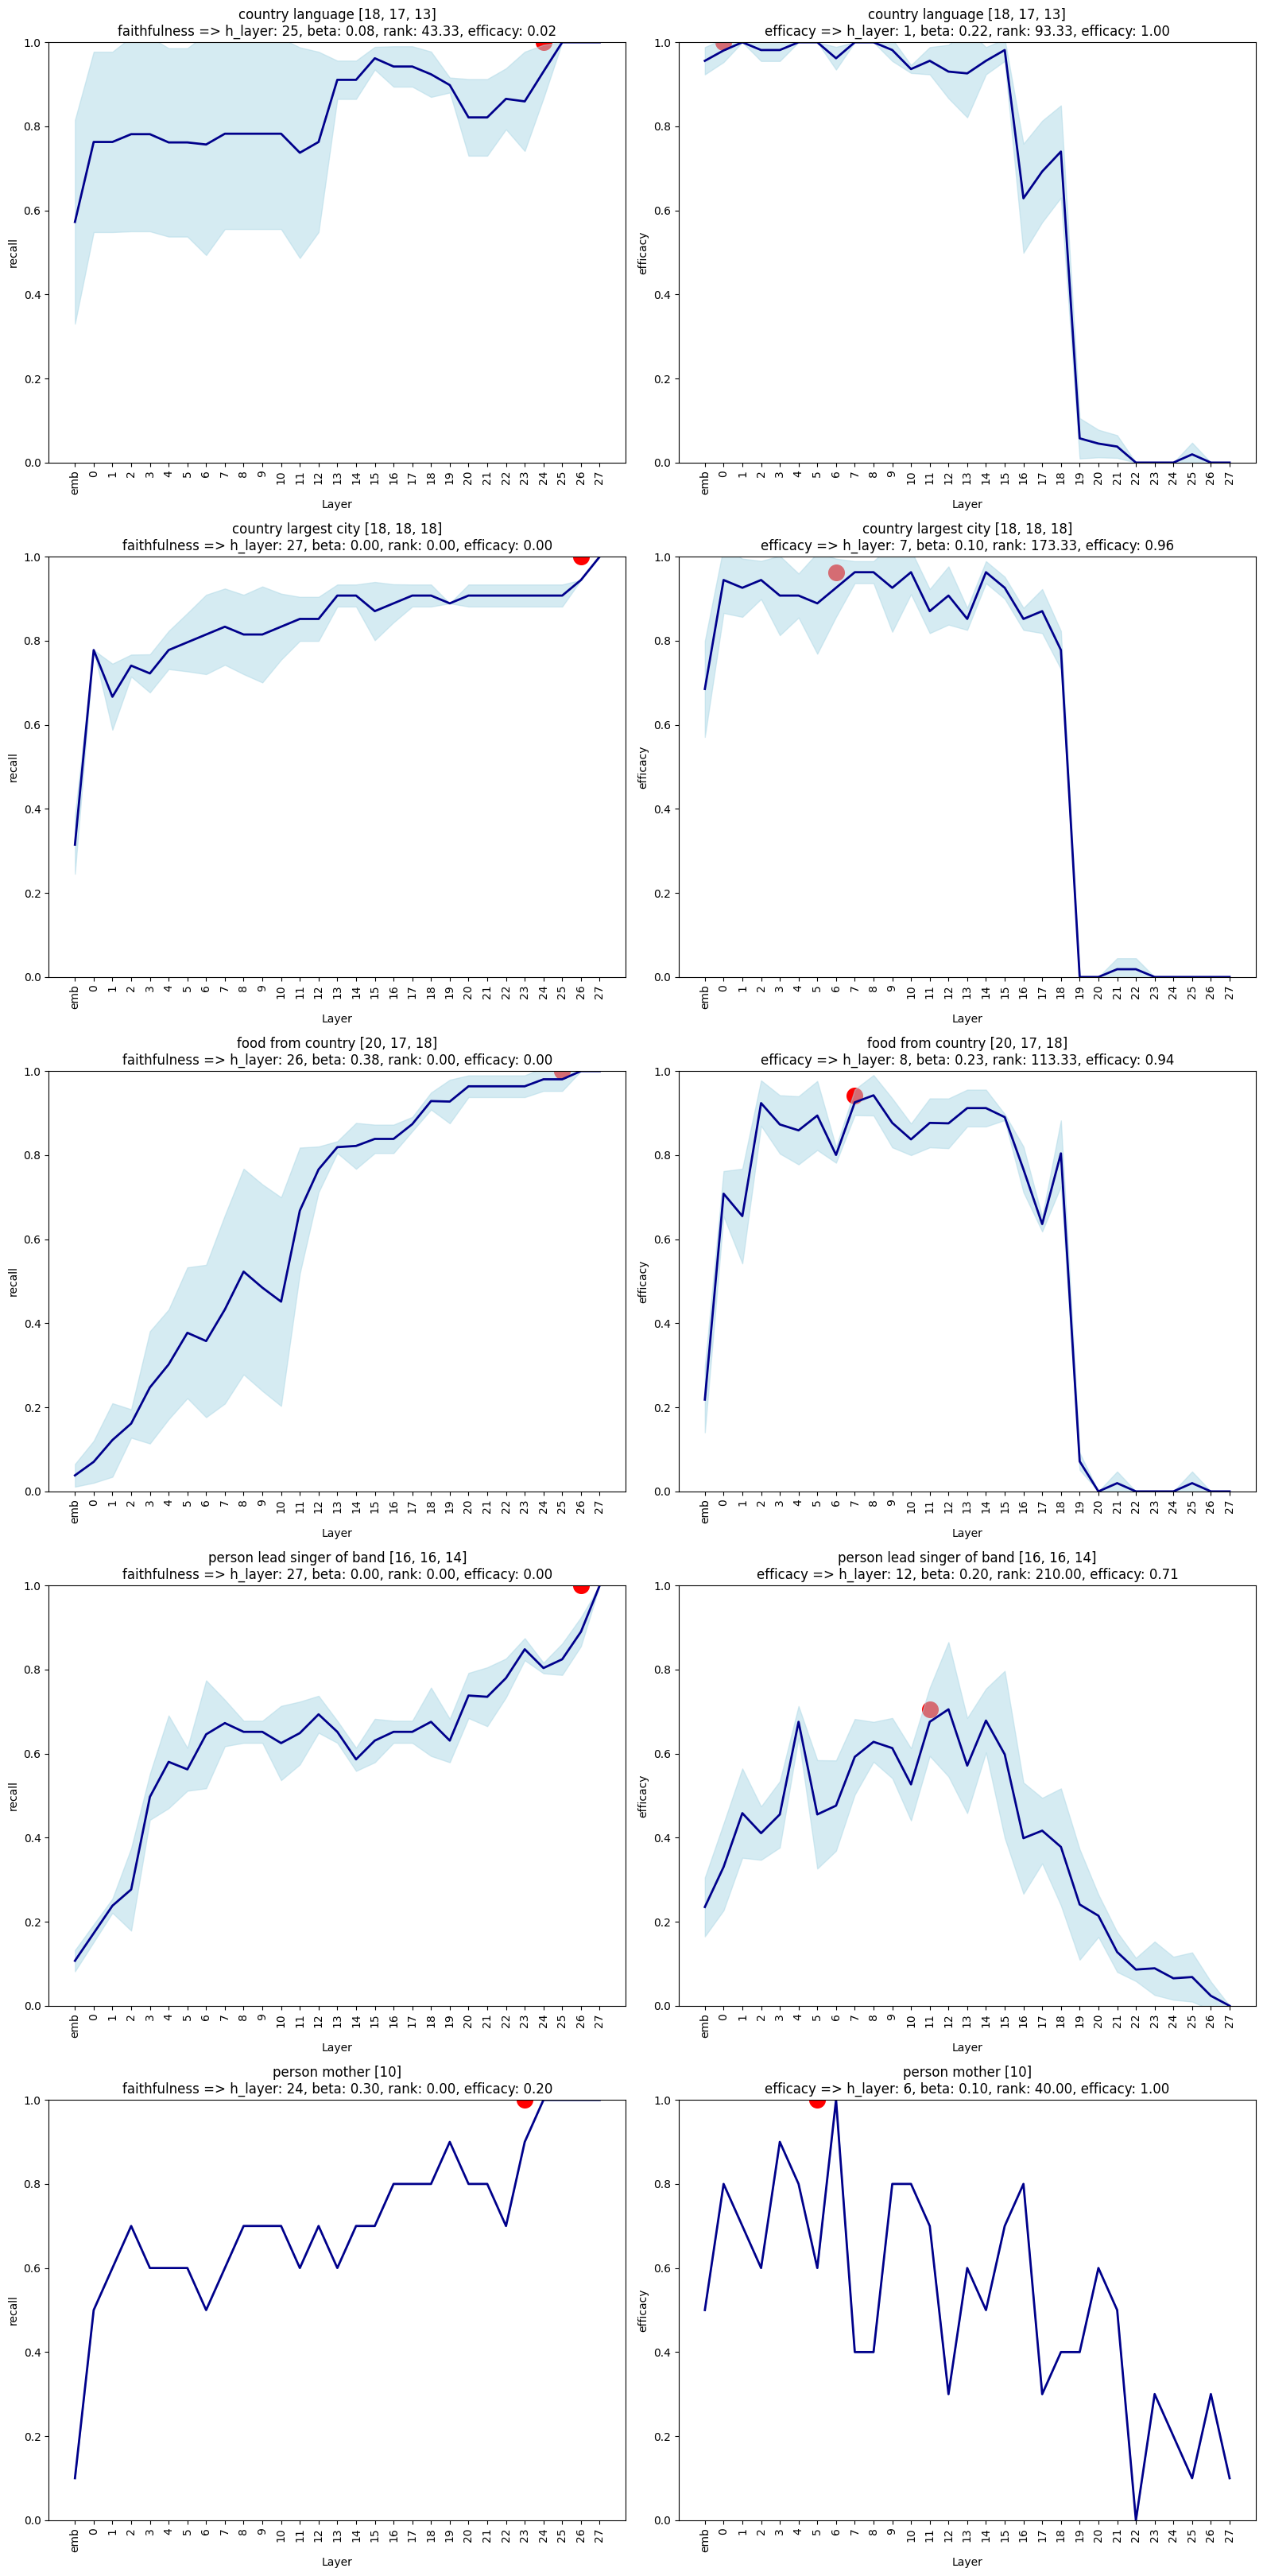

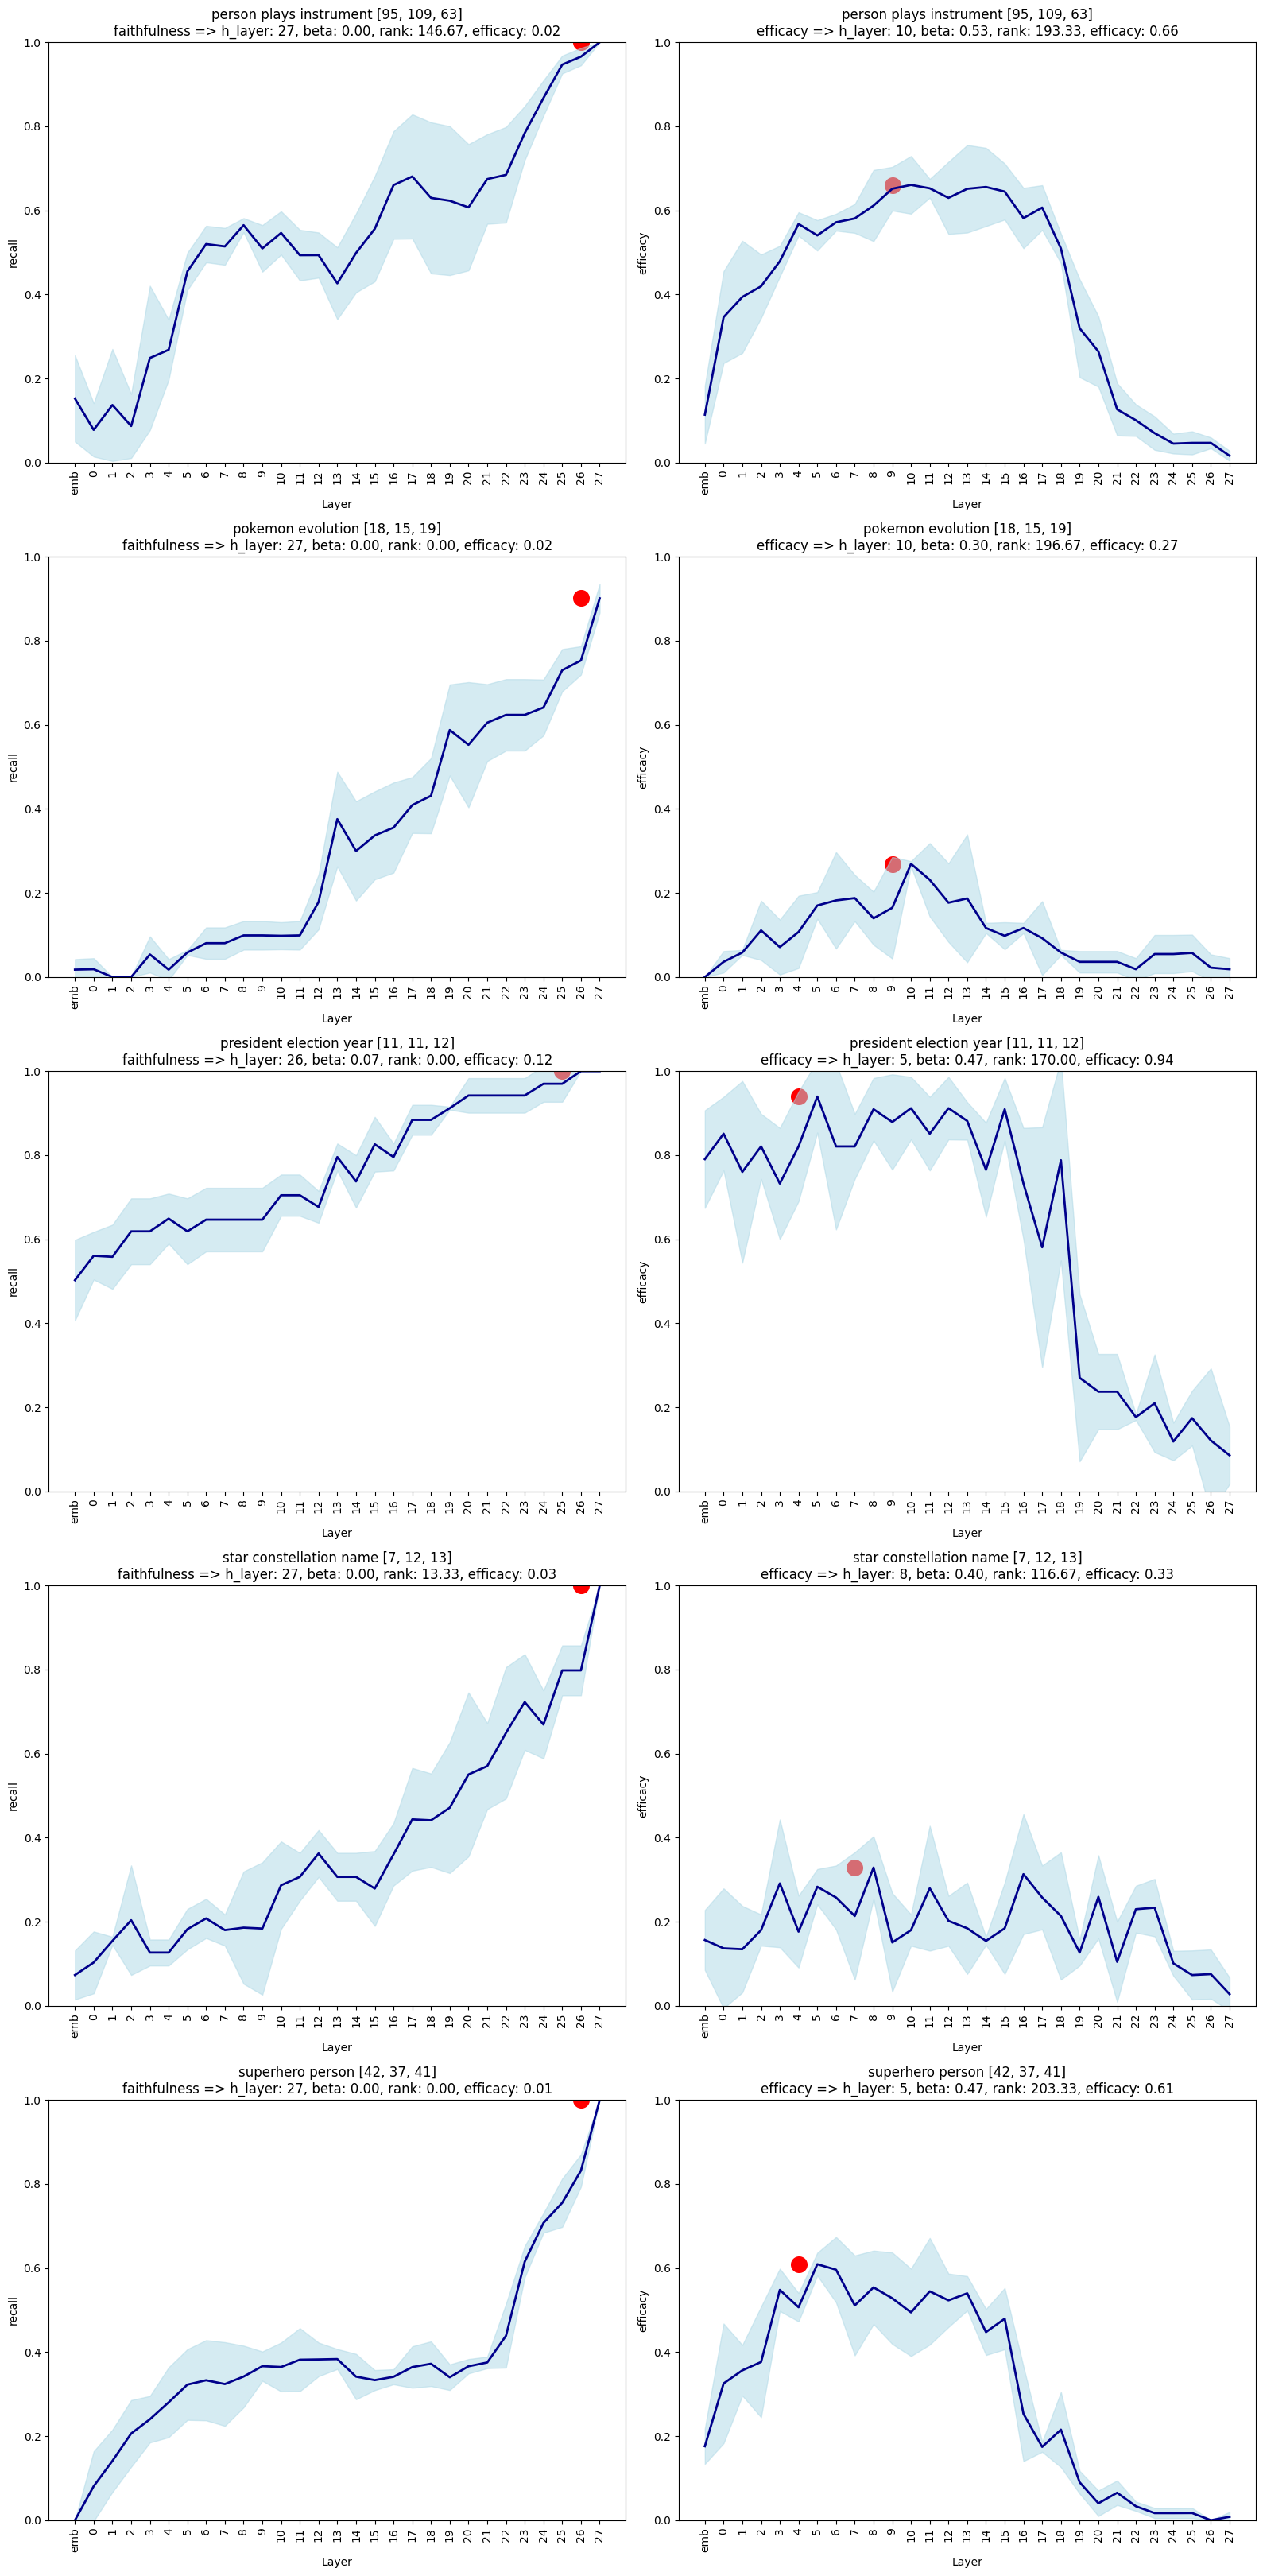

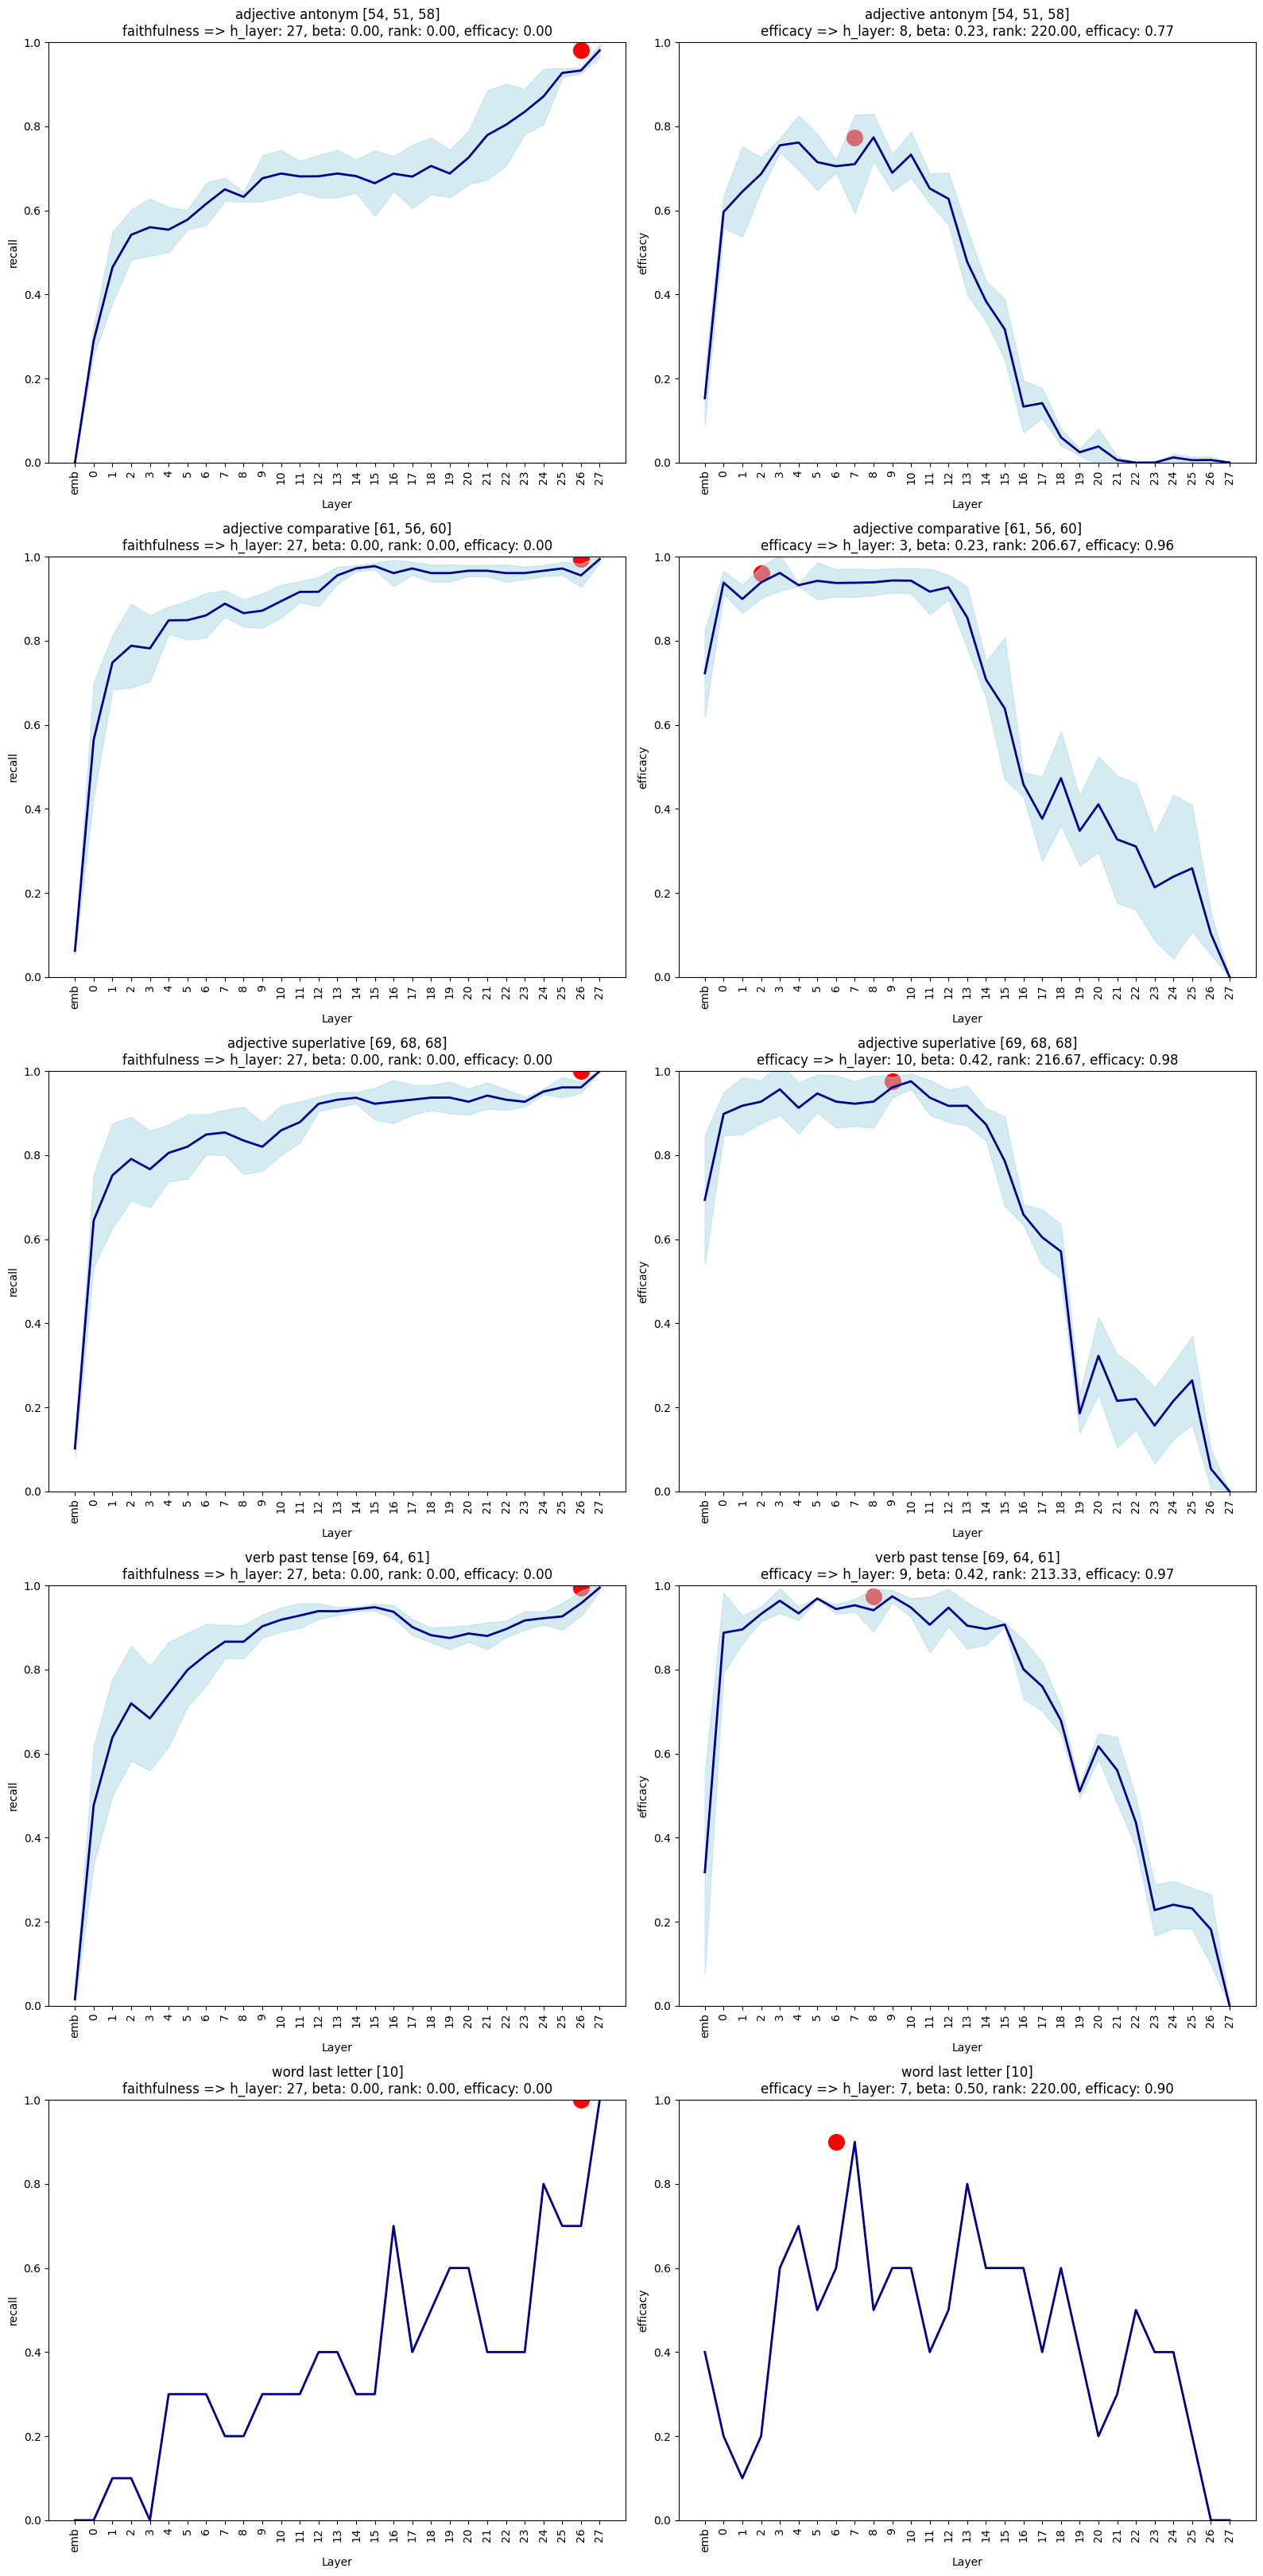

In [12]:
step_size = 5

for _from in range(0, len(filtered_results), step_size):
    _to = min(len(filtered_results), _from + step_size)
    n_subplots = len(filtered_results) * 3
    n_subplots = (_to - _from)  * 2
    ncols=2
    nrows=int(np.ceil(n_subplots/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6.5))
    if n_subplots == 1:
        axes = [axes]
    if nrows == 1:
        axes = [axes]

    ax_col, ax_row = 0, 0
    for i, (relation_name, relation_result) in list(enumerate(filtered_results.items()))[_from  : _to]:
        print(i, relation_name)
        # result = parse_results(sweep_results[relation_name])
        result = filtered_results[relation_name]
        plot_layerwise(axes[ax_row][0], result)
        plot_layerwise(axes[ax_row][1], result, attribute="efficacy", best_criterion="efficacy")
        # plot_layerwise(axes[ax_row][2], result, attribute="jh_norm", best_criterion="efficacy")
        ax_row += 1
        # break
    fig.tight_layout()
    fig.show()

In [24]:
sweep_path = f"../../results/sweep/{model_name}"

sweep_results = read_sweep_results(sweep_path)

In [25]:
for relation in sweep_results:
    sweep_results[relation] = parse_results(sweep_results[relation])

In [38]:
sweep_results.keys()

dict_keys(['person occupation', 'landmark in country', 'adjective antonym', 'person mother', 'country capital city', 'plays pro sport', 'person plays instrument', 'person university', 'city in country', 'food from country', 'company hq', 'occupation gender', 'name gender', 'word first letter', 'country language', 'object superclass', 'name religion', 'president election year', 'fruit outside color', 'superhero archnemesis', 'work location', 'person lead singer of band', 'task person type', 'country largest city', 'country currency', 'fruit inside color', 'task done by tool', 'verb past tense', 'star constellation name', 'pokemon evolution', 'product by company', 'name birthplace', 'word last letter', 'word sentiment', 'company CEO', 'superhero person', 'person father', 'substance phase of matter', 'person sport position', 'adjective superlative', 'adjective comparative'])

In [56]:
def get_recall_vs_efficacy_info(sweep_results, criterion = "best", threshold = 30):
    recalls = []
    efficacies = []
    pass_threshold = []
    for relation_name in sweep_results:
        if len(sweep_results[relation_name].trials) == 0:
            continue
        if criterion in ["best", "faithfulness"]:
            recalls.append(sweep_results[relation_name].best_by_faithfulness().recall.mean)
        else:
            recalls.append(sweep_results[relation_name].best_by_efficacy().recall.mean)
        if criterion in ["best", "efficacy"]:
            efficacies.append(sweep_results[relation_name].best_by_efficacy().efficacy.mean)
        else:
            efficacies.append(sweep_results[relation_name].best_by_faithfulness().efficacy.mean)
        
        test_samples = np.array([trial.n_test_samples for trial in sweep_results[relation_name].trials])
        pass_threshold.append(test_samples.min() >= threshold)

    return recalls, efficacies, pass_threshold

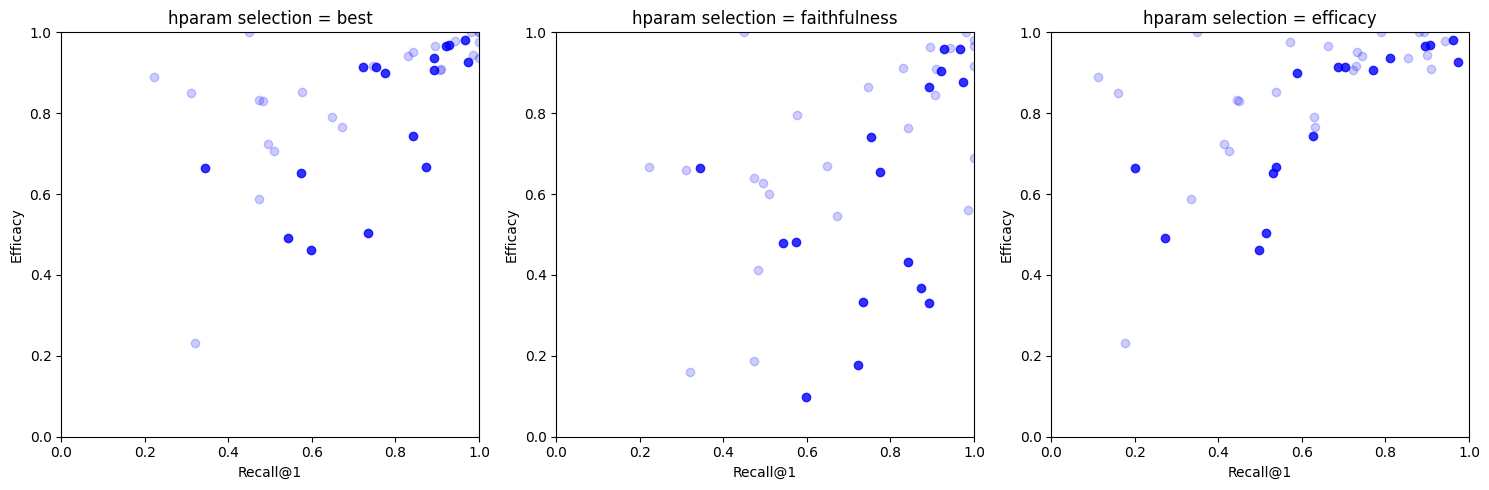

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for criterion, ax in zip(["best", "faithfulness", "efficacy"], axes):
    recalls, efficacies, pass_threshold = get_recall_vs_efficacy_info(sweep_results, criterion=criterion)
    for r, e, p in zip(recalls, efficacies, pass_threshold):
        alpha = .8 if p else 0.2
        ax.scatter(r, e, color="blue", alpha=alpha)

    ax.set_title(f"hparam selection = {criterion}")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Recall@1")
    ax.set_ylabel("Efficacy")

fig.tight_layout()
fig.show()

In [28]:
def read_and_parse_sweep_results(sweep_path):
    sweep_results = read_sweep_results(sweep_path)
    for relation in sweep_results:
        sweep_results[relation] = parse_results(sweep_results[relation])
    return sweep_results

In [29]:
sweep_single_path = f"../../results/sweep-single/{model_name}"
sweep_single = read_and_parse_sweep_results(sweep_single_path)

sweep_multi_path = f"../../results/sweep-multi/{model_name}"
sweep_multi = read_and_parse_sweep_results(sweep_multi_path)

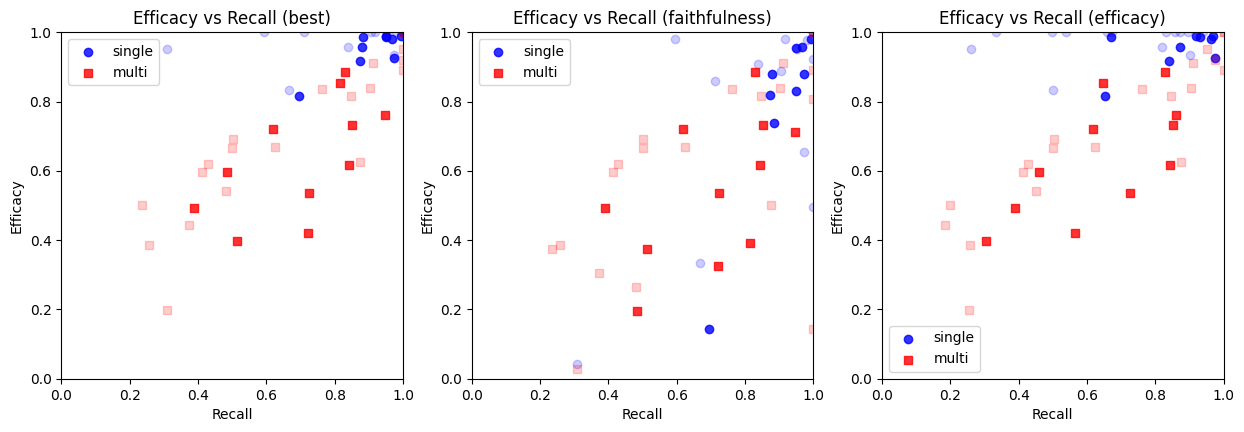

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4.5))

for criterion, ax in zip(["best", "faithfulness", "efficacy"], axes):
    single_recalls, single_efficacies, pass_single = get_recall_vs_efficacy_info(sweep_single, criterion=criterion)
    multi_recalls, multi_efficacies, pass_multi = get_recall_vs_efficacy_info(sweep_multi, criterion=criterion)
    labeled = False
    for r, e, p in zip(single_recalls, single_efficacies, pass_single):
        alpha = .8 if p else 0.2
        if (alpha == 0.8 and not labeled):
            ax.scatter(r, e, color = "blue", label = "single", alpha = alpha)
            labeled = True
        else:
            ax.scatter(r, e, color = "blue", alpha = alpha)

    labeled = False
    for r, e, p in zip(multi_recalls, multi_efficacies, pass_multi):
        alpha = .8 if p else 0.2
        alpha = .8 if p else 0.2
        if (alpha == 0.8 and not labeled):
            ax.scatter(r, e, color = "red", label = "multi", marker = "s", alpha = alpha)
            labeled = True
        else:
            ax.scatter(r, e, color = "red", marker = "s", alpha = alpha)

    ax.set_title(f"Efficacy vs Recall ({criterion})")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Efficacy")
    ax.legend()